# Titanic Survival Machine Learning Model

This notebook contains a **quick** attempt at building a machine learning model for predicting the surival of a passenger on the ship [Titanic](https://en.wikipedia.org/wiki/RMS_Titanic), based on the dataset hosted at [Kaggle](https://www.kaggle.com). The ultimate aim of this work is to demonstrate an archetypal 'data science workflow' that includes some data exploration, feature engineering, model training and selection and to yield a model that can be used in other projects downstream. We have already downloaded the data from Kaggle, in CSV format, to the `data` directory in this project's root directory. 

**WorkSheet done in DataLore**
Link:- https://datalore.jetbrains.com/notebook/PaaYOjq7apUBBrizLygpah/FOl7hCaUmyt6V8leyl6ArH/


## Package Imports and Environment Setup

In [1]:
import warnings
from datetime import datetime
from typing import Any, Callable, Dict, Iterable

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from seaborn import boxplot, countplot
from pandas import DataFrame
from numpy import ndarray
from sklearn.base import BaseEstimator
from sklearn.compose import make_column_transformer
from sklearn.ensemble import (
    GradientBoostingClassifier, RandomForestClassifier, VotingClassifier)
from sklearn.exceptions import NotFittedError
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import (
    BaseCrossValidator, GridSearchCV, StratifiedKFold, train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

warnings.filterwarnings('ignore')
sns.set()

## Load Dataset

In [2]:
data = pd.read_csv('/Users/Asus/Documents/Atmel Studio/MLtrain.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Summary Statistics for Numeric Data

In [3]:
(data
 .drop(['PassengerId'], axis=1)
 .describe())

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Data Description

- `Survived` - Survival (0 = No, 1 = Yes);
- `Pclass` - Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd);
- `Sex` - sex (male/female);
- `SibSp` - # of siblings / spouses aboard the Titanic (positive integer);
- `Parch` - # of parents / children aboard the Titanic (positive integer);
- `Ticket` - Ticket number (positive integer);
- `Fare` - Passenger fare (positive real);
- `Cabin` - Cabin number (string); and,
- `Embarked` - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

Note, that some children travelled only with a nanny, therefore `parch=0` for them.

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Visualisation

We introduce a simple class for automating the creation of basic visualisations that are suitable for a binary classification task and which treat continuous and non-continuous features differently.

In [5]:
class VizFeatureBinaryClass:
    """Automate binary classifier feature visualisation."""
    
    def __init__(self, label_col: str, feature_cols: Iterable[str],
                 data: DataFrame) -> None:
        plot_data = data[feature_cols + [label_col]]
        self.plots = {}
        for feature in feature_cols:
            fig, ax = plt.subplots()
            plt.close(fig)
            if plot_data[feature].dtype == 'float64':
                plot = boxplot(x=label_col, y=feature, data=plot_data, ax=ax)
            else:
                plot = countplot(x=feature, hue=label_col, data=plot_data,
                                 ax=ax)
            plot.set_title(feature)
            self.plots[feature] = plot
    
    def show(self, feature: str) -> None:
        """Display single plot."""
        plot = self.plots[feature]
        display(plot.figure)
        return None

    def show_all(self) -> None:
        """Display all plots."""
        for plot in self.plots.values():
            display(plot.figure)
        return None

We now use the visualiation class to take a cursory look at the impact of each feature on class label assignment.

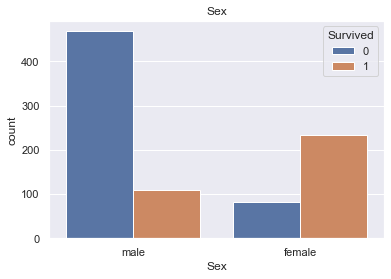

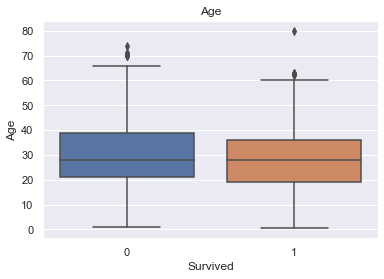

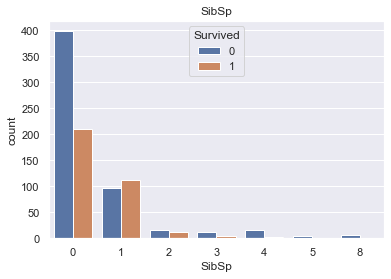

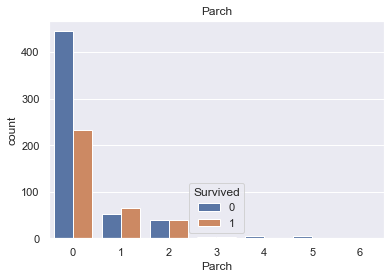

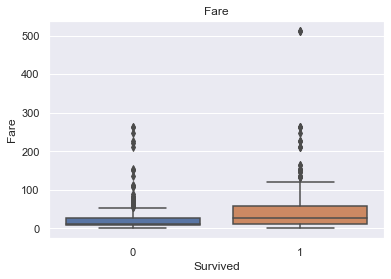

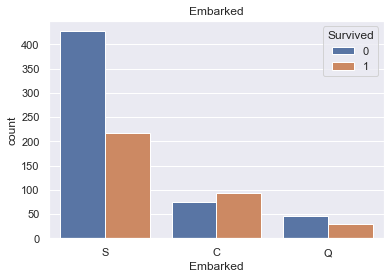

In [6]:
viz_features = VizFeatureBinaryClass(
    'Survived', ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], data)

viz_features.show_all()

## Extract Class Labels

The class labels for this classification task are in the `Survived` column of the training data. We split this column into seperate vector for model training.

In [7]:
labels = data.Survived.values

Take a look at the number of observations assigned to each class (i.e. look for the extent of the class imbalance).

In [8]:
survived_fraction = labels.sum() / labels.shape[0]
print(f'{survived_fraction:.1%} of passengers are classified as surviving')

38.4% of passengers are classified as surviving


## Spit Dataset into Train and Test Subsets

Use stratified sampling to ensure that classes are fairly represented in both train and test data.

In [9]:
train_data, test_data, y_train, y_test = train_test_split(
    data,
    labels,
    random_state=42,
    test_size=0.1,
    stratify=labels)

## Feature Engineering

We will **drop** the following columns from the final set of features:

- `PassengerId` - no apparent information content;
- `Survived` - i.e. the class labels we wish to predict;
- `Name` - no apparent predictive information content;
- `Ticket` - no apparent information content; and,
- `Cabin` - too many missing values to work with and `Pclass` and `Fare` should be adequate descriptors of cabin.

We will need to infer the missing values for the following columns (plus label each observation as having missing data):

- `Age` - using `Sex` and whether or not child or adult as inferred from `Name` and `Parch`; and,
- `Embarked` - assign to a new category labelled as `UNKNOWN`.

We will one-hot-encode the following categorical variables:

- `Pclass`;
- `Sex`; and,
- `Embarked`.

### Missing Data Imputers

In [10]:
age_imputer = SimpleImputer(strategy='mean')
embarked_imputer = SimpleImputer(strategy='constant', fill_value='UNKNOWN')

### Configure and Fit Feature Engineering Pipeline

In [11]:
feature_pipeline = make_column_transformer(
    (make_pipeline(age_imputer, StandardScaler()), ['Age']),
    (make_pipeline(embarked_imputer, OneHotEncoder()), ['Embarked']),
    (StandardScaler(), ['Fare']),
    (OneHotEncoder(), ['Pclass', 'Sex']))

feature_pipeline.fit(train_data);

### Transform Train and Test Data

In [12]:
X_train = feature_pipeline.transform(train_data)
X_test = feature_pipeline.transform(test_data)

X_train

array([[-1.04511068e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.04511068e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-2.72194763e-16,  0.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.32998578e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.55983382e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-9.68494661e-01,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

## Model Selection

We are fairly certain that the final decision boundary needs to be non-linear and that model training will benefit from models that can use weighted loss function. With this in mind, we will test the following model classes:

- Support Vector Machines (SVM);
- Random Forests (RF);
- Gradient Boosting Machine (GBM); and,
- Voting Classifier based on combining the above models.

### Experimental Setup

We will use 5-fold cross validation for hyper-parameter tuning and then asses performance on the test data.

In [16]:
cross_validator = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

### Test Metrics

We will use the following metrics to assess model performance:

- Area Under ROC Curve (AUC); and,
- accuracy.

In [17]:
metrics = {'auc': roc_auc_score,
           'accuray': accuracy_score}

### Automation

We define a simple class for automating grid-search, cross-validation and metric calculation across all model types.

In [18]:
MetricScorer = Callable[[Iterable[int], Iterable[int]], float]


class MLExperimentRunner:
    """Model training and metric calculation automation."""
    
    def __init__(self,
                 metrics: Dict[str, MetricScorer],
                 cross_validator: BaseCrossValidator,
                 model_selection_metric: str,
                 X_train: ndarray,
                 y_train: ndarray,
                 X_test: ndarray,
                 y_test: ndarray,) -> None:
        
        self.metrics = metrics
        self.cv = cross_validator
        self.selection_metric = model_selection_metric
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        return None
    
    def run(self, estimator: BaseEstimator,
            param_grid: Dict[str, Any], n_results: int = 10) -> BaseEstimator:
        """Run an experiment."""
        
        scorers = {name: make_scorer(metric)
                   for name, metric in self.metrics.items()}
        
        experiment = GridSearchCV(
            estimator, param_grid, scoring=scorers, cv=self.cv,
            refit=self.selection_metric, n_jobs=2)
        
        experiment.fit(self.X_train, self.y_train)
        
        self._display_results(experiment.cv_results_, n_results)
        self._display_test_metrics(experiment.best_estimator_)
        
        return experiment.best_estimator_

    def _display_test_metrics(self, estimator: BaseEstimator) -> None:
        """Print metrics for test data to stdout."""
        
        predictions = estimator.predict(self.X_test)
        results = {
            metric_name: metric_func(predictions, self.y_test)
            for metric_name, metric_func in self.metrics.items()}
        
        print('----------------------------------------')
        print('-- TEST DATA METRICS (best estimator) --')
        print('---------------------------------------')
        for metric_name, metric_value in results.items():
            print(f'{metric_name}: {metric_value:.4f}')
        print('----------------------------------------')
        
        return None

    def _display_results(self, cv_results: Dict[str, Any],
                         n_results: int) -> None:
        """Display cross validation results as DataFrame."""
        
        cv_data = DataFrame(cv_results)

        metric_col_names = [
            e 
            for name in self.metrics.keys()
            for e in [f'mean_test_{name}', f'std_test_{name}']]

        selection_metric_col_name = f'mean_test_{self.selection_metric}'

        cv_data.sort_values(
            by=selection_metric_col_name, ascending=False, inplace=True)
        cv_data.reset_index(inplace=True)

        display(cv_data[['params'] + metric_col_names].head(n_results))

        return None

And we then generate an instance of the experiment runner for the current task.

In [19]:
ml_experiment = MLExperimentRunner(
    metrics, cross_validator, 'auc', X_train, y_train, X_test, y_test)

### Support Vector Machine

In [20]:
svm_model = ml_experiment.run(
    SVC(class_weight='balanced', gamma='auto', probability=True),
    {'C': [0.01, 0.1, 1, 10, 100],
     'kernel': ['linear', 'rbf']})

,params,mean_test_auc,std_test_auc,mean_test_accuray,std_test_accuray
0,"{'C': 1, 'kernel': 'rbf'}",0.786411,0.037273,0.800256,0.035314
1,"{'C': 100, 'kernel': 'rbf'}",0.783010,0.031819,0.791498,0.036847
2,"{'C': 10, 'kernel': 'rbf'}",0.774402,0.034419,0.783998,0.038958
3,"{'C': 0.01, 'kernel': 'linear'}",0.771900,0.032363,0.791514,0.030997
4,"{'C': 0.1, 'kernel': 'linear'}",0.770287,0.034365,0.790264,0.032724
5,"{'C': 1, 'kernel': 'linear'}",0.770287,0.034365,0.790264,0.032724
6,"{'C': 10, 'kernel': 'linear'}",0.770287,0.034365,0.790264,0.032724
7,"{'C': 100, 'kernel': 'linear'}",0.770287,0.034365,0.790264,0.032724
8,"{'C': 0.1, 'kernel': 'rbf'}",0.769335,0.037510,0.785280,0.036069
9,"{'C': 0.01, 'kernel': 'rbf'}",0.510333,0.008817,0.624216,0.004890


----------------------------------------
-- TEST DATA METRICS (best estimator) --
---------------------------------------
auc: 0.7429
accuray: 0.7556
----------------------------------------


### Random Forest

In [21]:
rf_model = ml_experiment.run(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    {'n_estimators': [10, 100, 1000],
     'min_samples_split': [2, 4, 6, 8, 10],
     'max_depth': [2, 4, 6, 8, 10, None]})

,params,mean_test_auc,std_test_auc,mean_test_accuray,std_test_accuray
0,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.824072,0.034608,0.841436,0.030572
1,"{'max_depth': 10, 'min_samples_split': 6, 'n_e...",0.821507,0.032241,0.835186,0.030354
2,"{'max_depth': 10, 'min_samples_split': 4, 'n_e...",0.820661,0.034847,0.836444,0.030258
3,"{'max_depth': 8, 'min_samples_split': 2, 'n_es...",0.817683,0.037976,0.832686,0.035974
4,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.816805,0.033574,0.833936,0.030361
5,"{'max_depth': 8, 'min_samples_split': 4, 'n_es...",0.816224,0.036596,0.830194,0.034630
6,"{'max_depth': 10, 'min_samples_split': 4, 'n_e...",0.814997,0.027287,0.830194,0.024607
7,"{'max_depth': 8, 'min_samples_split': 2, 'n_es...",0.813384,0.041459,0.828936,0.037938
8,"{'max_depth': 8, 'min_samples_split': 4, 'n_es...",0.813019,0.035733,0.827694,0.033075
9,"{'max_depth': 10, 'min_samples_split': 6, 'n_e...",0.812930,0.030457,0.827694,0.027103


----------------------------------------
-- TEST DATA METRICS (best estimator) --
---------------------------------------
auc: 0.8150
accuray: 0.8222
----------------------------------------


### Gradient Boosting Machine

In [22]:
gbm_model = ml_experiment.run(
    GradientBoostingClassifier(random_state=42),
    {'n_estimators': [10, 100, 1000],
     'learning_rate': [0.01, 0.1, 1, 10],
     'min_samples_split': [2, 4, 6, 8, 10],
     'max_depth': [2, 4, 8, 10, None]})

,params,mean_test_auc,std_test_auc,mean_test_accuray,std_test_accuray
0,"{'learning_rate': 0.1, 'max_depth': 2, 'min_sa...",0.812517,0.023938,0.830225,0.023079
1,"{'learning_rate': 0.1, 'max_depth': 2, 'min_sa...",0.812490,0.022827,0.830217,0.022105
2,"{'learning_rate': 0.1, 'max_depth': 2, 'min_sa...",0.812490,0.022827,0.830217,0.022105
3,"{'learning_rate': 0.1, 'max_depth': 2, 'min_sa...",0.810877,0.021381,0.828975,0.021406
4,"{'learning_rate': 0.1, 'max_depth': 2, 'min_sa...",0.810480,0.025044,0.827733,0.025362
5,"{'learning_rate': 0.01, 'max_depth': 4, 'min_s...",0.808810,0.035068,0.830202,0.032017
6,"{'learning_rate': 0.01, 'max_depth': 4, 'min_s...",0.808022,0.031703,0.827710,0.029238
7,"{'learning_rate': 0.01, 'max_depth': 4, 'min_s...",0.807800,0.031155,0.828952,0.028733
8,"{'learning_rate': 0.1, 'max_depth': 4, 'min_sa...",0.806790,0.031459,0.827710,0.029238
9,"{'learning_rate': 0.01, 'max_depth': 4, 'min_s...",0.806790,0.032476,0.827702,0.029280


----------------------------------------
-- TEST DATA METRICS (best estimator) --
---------------------------------------
auc: 0.7911
accuray: 0.8000
----------------------------------------


### Voting Classifier

In [23]:
voting_model = ml_experiment.run(
    VotingClassifier([
        ('svm', svm_model), ('rf', rf_model), ('gbm', gbm_model)]),
    {'voting': ['hard', 'soft']})

,params,mean_test_auc,std_test_auc,mean_test_accuray,std_test_accuray
0,{'voting': 'soft'},0.82055,0.043340,0.837702,0.039332
1,{'voting': 'hard'},0.81862,0.040063,0.837717,0.035502


----------------------------------------
-- TEST DATA METRICS (best estimator) --
---------------------------------------
auc: 0.8150
accuray: 0.8222
----------------------------------------


## Assemble Final Prediction Pipeline

We will choose the random forest model to combine with the feature pipeline and then persist to disk.

In [24]:
prediction_pipeline = make_pipeline(feature_pipeline, rf_model)

### Re-Fit Model on Entire Dataset

In [25]:
prediction_pipeline.fit(data, data.Survived)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='UNKNOWN',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                         

### Test Pipeline

In [26]:
prediction_pipeline.predict(test_data)

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1], dtype=int64)

### Persist Model

In [32]:
base_model_name = 'titanic-ml'
directory = 'models'
timestamp = datetime.now().isoformat(timespec='seconds')

#joblib.dump(prediction_pipeline, f'{directory}/{base_model_name}-{timestamp}.joblib')
joblib.dump(prediction_pipeline,'models/titanic-ml.joblib')

['models/titanic-ml.joblib']